In [1]:
from PIL import Image, ImageDraw
import sys, os
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import geoio
import math
#from osgeo 

import gdal, gdalnumeric, ogr, osr
import pyproj

In [2]:
import pandas as pd
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [4]:
#Accedo a los puntos de las transectas y los guardo en el objeto pandas llamado df

file_svc = "C:\\Users\\Administrador\Desktop\DeepLearningInternship\Crop Yield Prediction\Crop Type Classification model - CNN\First\T28_Pringles4.csv"
df = pd.read_csv(file_svc)
print(df.head()) #Muestro los primeros 5 elementos

       Lat1     Long1    EstadoCultivo
0 -37.75737 -61.14537         Barbecho
1 -37.78152 -61.15872  Verdeo invierno
2 -37.78248 -61.17755         Barbecho
3 -37.78018 -61.17357    Campo natural
4 -37.78850 -61.18501    Campo natural


In [7]:
#ACCEDO A LA IMAGEN SATELITAL LLAMADA LC08_L1TP_226086_20170116_20170311_01_T1_sr que es la correspondiente a la transecta
#previamente cargada. Guardo las 7 bandas correspondientes en los objetos gdal band1, band2, ... , band7

b1 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band1.tif"
b2 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band2.tif"
b3 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band3.tif"
b4 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band4.tif"
b5 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band5.tif"
b6 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band6.tif"
b7 = r"E:\Imágenes Satelitales\2017\226_86\1\LC08_L1TP_226086_20170116_20170311_01_T1_sr_band7.tif"

band1 = gdal.Open(b1, gdal.GA_ReadOnly)
band2 = gdal.Open(b2, gdal.GA_ReadOnly)
band3 = gdal.Open(b3, gdal.GA_ReadOnly)
band4 = gdal.Open(b4, gdal.GA_ReadOnly)
band5 = gdal.Open(b5, gdal.GA_ReadOnly)
band6 = gdal.Open(b6, gdal.GA_ReadOnly)
band7 = gdal.Open(b7, gdal.GA_ReadOnly)

In [9]:
#Convierto las bandas en numpy arrays. De esta manera, los datos de la imagen serán numéricos y quedarán listos para usarse
#en el entrenamiento de la red clasificadora. Esas bandas las meto en la matriz "imagen"

red_array = band4.ReadAsArray().astype(np.float32) #segun wikipedia, las bandas 4,3 y 2 son el RGB
#green_array = band3.ReadAsArray().astype(np.float32)
#blue_array = band2.ReadAsArray().astype(np.float32)

imagen = (np.zeros(red_array.size*7, dtype = np.float32)).reshape(red_array.shape[0],red_array.shape[1],7)

imagen[:,:,0] = band1.ReadAsArray().astype(np.float32) 
imagen[:,:,1] = band2.ReadAsArray().astype(np.float32) 
imagen[:,:,2] = band3.ReadAsArray().astype(np.float32)
imagen[:,:,3] = band4.ReadAsArray().astype(np.float32) 
imagen[:,:,4] = band5.ReadAsArray().astype(np.float32) 
imagen[:,:,5] = band6.ReadAsArray().astype(np.float32) 
imagen[:,:,6] = band7.ReadAsArray().astype(np.float32)

In [20]:
#TRANSFORMO LOS PUNTOS DE LA TRANSECTA que originalmente estan en el sistema de referencia WSG84. La imagen satelital está
#en el sistema de referencia UTM y encima cuando la convertis a numpy array cambia su proyección. Entonces hay que hacer
#un par de transformaciones.

#Esto esta basado en mi post de stackoverflow de acá: https://gis.stackexchange.com/questions/331927/cutting-a-portion-of-a-satellite-image-based-on-coordinates-in-gdal

source = osr.SpatialReference() #El espacio de referencias de las coordenadas (WGS84) lo guardo en "source"
source.ImportFromEPSG(4326)  # WGS84 4326

crs = band1.GetProjection()
target = osr.SpatialReference() #El espacio de referencias de la imagen lo guardo en "target"
target.ImportFromWkt(crs)

transform = osr.CoordinateTransformation(source, target) #Genero una matriz de transformacion que va de source a target

mx = np.zeros(df.Long1.size) #Genero arreglos para guardar las coordenadas convertidas
my = np.zeros(df.Long1.size)

for i in range(df.Long1.size):
    lon, lat = df.Long1[i], df.Lat1[i]
    mx[i], my[i], z = transform.TransformPoint(lon, lat) #Convierto las coordenadas al espacio de referencias de la imagen

    
gt = band1.GetGeoTransform()  # los Geotransforms permiten la conversion de pixel a coordenadas de mapa
inv_gt = gdal.InvGeoTransform(gt)  # La invierto para poder ir de coordenadas de mapa a pixel


px = np.zeros(df.Long1.size) #Creo px y py. Aquí estaran las coordenadas originales pero convertidas a
py = np.zeros(df.Long1.size) #coordenadas pixeles en la imagen

# Appico esa geotransform y trunco los valores obteniendo así las coordenadas en pixeles
for i in range(df.Long1.size):
    px[i], py[i] = (math.floor(f) for f in gdal.ApplyGeoTransform(inv_gt, mx[i], my[i]))
    

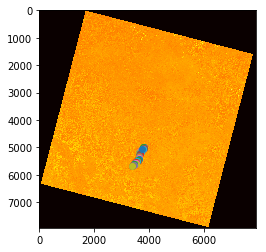

In [24]:
#GRAFICO SOLO EL CANAL ROJO y encima todos los puntos de la transecta.
#Tambien exporto la imagen en resolucion alta. Con esto verifico que la conversion se hizo correctamente
#Esto es abriendo el software QGIS y viento que las coordenadas estan donde deben estar

plt.imshow(red_array, cmap = 'hot')
for i in range(df.Long1.size):
    plt.plot(px[i],py[i],'o')

plt.savefig('red_band.png', dpi=1500)
#plt.hist(red_array.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

# Perfecto. El primer objetivo esta cumplido. Ahora voy con el objetivo 2 que consiste en generar un dataset a partir de porciones de la imágen satelital

In [135]:
dataset = np.zeros(df.Long1.size*30*30*7)
dataset = dataset.reshape(df.Long1.size,30,30,7)

#El dataset va a ser de tamaño 71 (o sea df.Long1.size, o sea la cantidad de puntos de cada transecta)
#Y va a consistir de pequeñas imagenes de 30*30 pixeles
#Esas pequeñas imagenes son de 7 canales. Por eso el shape queda de 71*30*30*7

In [138]:
for i in range(dataset.shape[0]):
    #dataset[i] = imagen[  px[i] : px[i]+14  ,  py[i] : py[i]+14   ,:]
    dataset[i] = imagen[  int(px[i])-15 : int(px[i])+15  ,  int(py[i])-15 : int(py[i])+15   ,:]

In [139]:
dataset.shape

(71, 30, 30, 7)

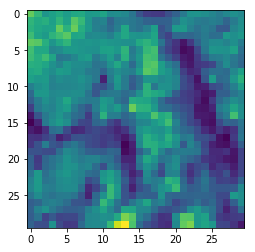

In [140]:
#ploteo un ejemplo de BARBECHO (banda roja)
plt.imshow((dataset[0])[:,:,4])

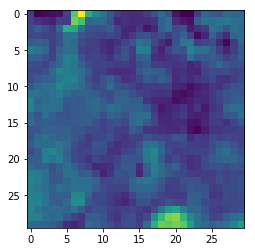

In [141]:
#ploteo un ejemplo de CAMPO NATURAL (banda roja)
plt.imshow((dataset[4])[:,:,4])

In [143]:
#Ahora hay que añadir los labels. Para empezar con algo simple solo voy a identificar dos clases "campo natural" y "otros".
#Luego se podrá complejizar tanto como se desee.

In [142]:
X = dataset #esto va a ser la entrada a la red

In [144]:
Y = np.zeros(dataset.shape[0])
for i in range (df.Long1.size):
    if (df.EstadoCultivo[i] == 'Campo natural'):
        Y[i] = 1

In [145]:
Y
#Listo, Y es la salida de la red. Si es un 1 es campo natural y si es un 0 es otro tipo de cultivo

array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0.])

# Excelente, el segundo objetivo esta cumplido. Solo resta generar un modelo de red CNN que pueda entrenarse a partir de ese dataset

In [92]:
import tensorflow as tf
import tensorflow.keras as kr

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image #Esto permite manipular imagenes

Using TensorFlow backend.


In [146]:
lr = 0.01 #learning rate
nn = [32, 32, 64, 64,1]  # número de neuronas por capa.

In [152]:
model = Sequential()
model.add(Conv2D(nn[0], (3, 3), input_shape=(30, 30,7))) #Aca se esta agregando un nn[0] filtros de convolucion (o sea 32)
# Cada filtro es de 3x3 y la entrada a esta capa es de 15x15 y de 7 canales
model.add(Activation('relu')) #La funcion de activacion es ReLU
model.add(MaxPooling2D(pool_size=(2, 2))) #Se hace un MaxPool de 2x2 para downsamplear la entrada y asi reducir el overfitting

model.add(Conv2D(nn[1], (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(nn[2], (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

In [153]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(nn[3])) #Perceptron multi capa, 64 neuronas
model.add(Activation('relu')) 
model.add(Dropout(0.5)) #Eliminas el 50% de las neuronas reduciendo asi el overfitting
model.add(Dense(nn[4])) #Una neurona solita
model.add(Activation('sigmoid')) #Sigmoide en vez de ReLU para que la salida sea mas binaria

model.compile(loss='binary_crossentropy', #Funcion de perdida
              optimizer='rmsprop', #Optimizador
              metrics=['accuracy']) #Metricas
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        2048      
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 12, 12, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
__________

In [149]:
model.fit(X,Y, epochs=100, validation_split=0.5)
model.save_weights('first_try.h5')  # always save your weights after training or during training
model.save('modelo1')

Train on 35 samples, validate on 36 samples
Epoch 1/100
35/35 [==============================] - 1s 32ms/step - loss: 12.2984 - acc: 0.2286 - val_loss: 10.1854 - val_acc: 0.3611
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 12.7639 - acc: 0.2000 - val_loss: 10.1854 - val_acc: 0.3611
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 10.3812 - acc: 0.3429 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.9210 - acc: 0.9429 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 2.2976 - acc: 0.8571 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 1.3816 - acc: 0.9143 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 2.2976 - acc: 0.8571 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 8/100
35/35 [==============

Epoch 63/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 64/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 65/100
35/35 [==============================] - 0s 4ms/step - loss: 2.2976 - acc: 0.8571 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 66/100
35/35 [==============================] - 0s 4ms/step - loss: 2.2976 - acc: 0.8571 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 67/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 68/100
35/35 [==============================] - 0s 4ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 69/100
35/35 [==============================] - 0s 4ms/step - loss: 1.3816 - acc: 0.9143 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 70/100
35/35 [==============================] - 0s 4ms/step - loss: 1.

Tiene mucho overfitting asi que voy a correr solo 4 epochs

In [154]:
model.fit(X,Y, epochs=4, validation_split=0.5)
model.save_weights('first_try.h5')  # always save your weights after training or during training
model.save('modelo1')

Train on 35 samples, validate on 36 samples
Epoch 1/4
35/35 [==============================] - 1s 34ms/step - loss: 12.6829 - acc: 0.2000 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 2/4
35/35 [==============================] - 0s 4ms/step - loss: 4.4169 - acc: 0.7143 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 3/4
35/35 [==============================] - 0s 5ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389
Epoch 4/4
35/35 [==============================] - 0s 4ms/step - loss: 1.8421 - acc: 0.8857 - val_loss: 5.8204 - val_acc: 0.6389


In [163]:
#Verifico que le pegue a algunas entradas
for i in range(70):
    input = X[i].reshape(1,30,30,7) #Esto es asi por la documentacion de keras.
    #Lo que le pidas predecir debe estar en esas dimensiones si o si
    output = model.predict(input)
    print("El modelo precide",output)
    print("Y la respuesta correcta es", Y[i])

El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta

Con eso me doy cuenta que el modelo siempre arroja el resultado 0, no importa lo que le pongas a la entrada. Entonces voy a modificar el modelo creando un "model2" con el que posiblemente pueda arreglar el problema

In [203]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(30, 30,7)))
model2.add(Activation('relu')) #La funcion de activacion es ReLU
model2.add(MaxPooling2D(pool_size=(2, 2))) #Se hace un MaxPool de 2x2 para downsamplear la entrada y asi reducir el overfitting
model2.add(Conv2D(16, (2, 2)))
model2.add(Activation('relu')) #La funcion de activacion es ReLU
model2.add(MaxPooling2D(pool_size=(4, 4))) #Se hace un MaxPool de 2x2 para downsamplear la entrada y asi reducir el overfitting
model2.add(Flatten()) 
model2.add(Dense(64, input_shape=(30,30,7), activation='relu'))
model2.add(Dropout(0.5))
#model2.add(Dense(64, activation='relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', #Funcion de perdida
              optimizer='rmsprop', #Optimizador
              metrics=['accuracy']) #Metricas

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 32)        2048      
_________________________________________________________________
activation_61 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 13, 13, 16)        2064      
_________________________________________________________________
activation_62 (Activation)   (None, 13, 13, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 144)               0         
__________

In [204]:
model2.fit(X,Y, epochs=15, validation_split=0.2)
model2.save_weights('second_try.h5')  # always save your weights after training or during training
model2.save('modelo2')

Train on 56 samples, validate on 15 samples
Epoch 1/15
56/56 [==============================] - 2s 32ms/step - loss: 12.3850 - acc: 0.2143 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 2/15
56/56 [==============================] - 0s 2ms/step - loss: 4.5738 - acc: 0.7143 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 3/15
56/56 [==============================] - 0s 3ms/step - loss: 3.7135 - acc: 0.7679 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 4/15
56/56 [==============================] - 0s 3ms/step - loss: 3.7197 - acc: 0.7679 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 5/15
56/56 [==============================] - 0s 3ms/step - loss: 2.5779 - acc: 0.8393 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 6/15
56/56 [==============================] - 0s 3ms/step - loss: 2.8625 - acc: 0.8214 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 7/15
56/56 [==============================] - 0s 3ms/step - loss: 3.7197 - acc: 0.7679 - val_loss: 11.8199 - val_acc: 0.2667
Epoch 8/15
56/56 [===================

In [206]:
for i in range(70):
    input = X[i].reshape(1,30,30,7) #Esto es asi por la documentacion de keras.
    #Lo que le pidas predecir debe estar en esas dimensiones si o si
    output = model2.predict(input)
    print("El modelo precide",output)
    print("Y la respuesta correcta es", Y[i])

El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 1.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta es 0.0
El modelo precide [[0.]]
Y la respuesta correcta

Ya estaría terminado todo. Pero me sigue haciendo lo mismo, la red da siempre el resultado0 sin importar cual sea la entrada. Quizas el problema sea porque el dataset es muy pequeño o porque el modelo no es adecuado. Quizas habría que upsamplear las imagenes y recien ahi convolucionarlas. Eso quedara para futuros notebooks